In [1]:
from pathlib import Path 
import tarfile
import urllib.request

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector, make_column_transformer

from sklearn.linear_model import LinearRegression, LogisticRegression, SGDRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import VotingRegressor, BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.ensemble import StackingRegressor

from sklearn.tree import plot_tree

from sklearn.metrics import mean_squared_error

In [2]:
def load_housing_data():
    tarball_path = Path("datasets/housing.tgz") 
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz" 
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets") 
    return pd.read_csv(Path("datasets/housing/housing.csv"))

def split_train_test(X, y, test_ratio = 0.2):

    #---stratified sampling
    X_columns = X.columns
    y_columns = y.columns
    data = pd.concat([X,y], axis = 1)
        
    df_income_cat = data.copy()
    df_income_cat["income_cat"] = pd.cut(df_income_cat["median_income"],
                                       bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                                       labels=[1, 2, 3, 4, 5])

    dftrain_strat, dftest_strat = train_test_split(
        df_income_cat, test_size=test_ratio, stratify=df_income_cat["income_cat"], random_state=42)

    dftrain_strat = dftrain_strat.drop(['income_cat'], axis = 1)
    dftest_strat = dftest_strat.drop(['income_cat'], axis = 1)

    X_train = dftrain_strat[X_columns]
    y_train = dftrain_strat[y_columns]
    
    X_test = dftest_strat[X_columns]
    y_test = dftest_strat[y_columns]
    
    return X_train, X_test, y_train, y_test

Xtrain_prepared_col_names = []

def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]  # feature names out

def fill_na(X, strategy = 'median'):
    #X: ndarray array of shape (n_samples, n_features)
    #return ndarray of shape (n_samples, n_features) with missing values filled by the strategy

    imputer = SimpleImputer(strategy = strategy)
    imputer.fit(X)

    return imputer.transform(X)

def get_outlier_indices(X):
    #X: ndarray of shape (n_samples, n_features)
    #y: label of shape (n_samples, k = 1)
    #return the indices of outliers in X
    
    isolation_forest = IsolationForest(random_state = 42)
    outlier_pred = isolation_forest.fit_predict(X)

    return outlier_pred

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name))

def prepare_for_train(Xtrain, Xtest, ytrain, ytest):
    
    #prepare data for training
    #---create 2 pipelines for nummerical columns and catergorical columns
    #---then merge them into one
    
    #Note DecisionTree can work with missing values and different scale but RandomForest cannot

    num_pipeline = make_pipeline(SimpleImputer(strategy = 'median'),
                                 StandardScaler())

    #num_pipeline = make_pipeline('passthrough')

    cat_pipeline = make_pipeline(SimpleImputer(strategy = "most_frequent"),\
                                 OneHotEncoder(handle_unknown='ignore'))


    preprocessing = ColumnTransformer([("num", num_pipeline, make_column_selector(dtype_include=np.number)),\
                                       ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
                                       ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
                                       ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
                                       ("people_per_house", ratio_pipeline(), ["population", "households"])]
                                     )
    
    
   



    #---drop outliers in the training set outside the pipeline, do not drop outliers in the test
    """
    DecisionTree can work with outliers, so we do not need this code
    I mostly use DecisionTree throughout this assignment, so I chose again to not drop outliers
    
    
    Xtrain_num = Xtrain.select_dtypes(include=[np.number])
    Xtrain_num = fill_na(Xtrain_num)
    outlier_indices = get_outlier_indices(Xtrain_num)

    Xtrain = Xtrain.iloc[outlier_indices == 1]
    ytrain = ytrain.iloc[outlier_indices == 1]
    """

    #---pass Xtrain, Xtest thru the pipeline to get the prepared versions 
    
    Xtrain_prepared = preprocessing.fit_transform(Xtrain, ytrain)

    Xtest_prepared = preprocessing.fit_transform(Xtest, ytest)

    ytrain_prepared, ytest_prepared = ytrain, ytest
    
    ytrain_prepared, ytest_prepared = np.ravel(ytrain_prepared, ), np.ravel(ytest_prepared, )

    global Xtrain_prepared_col_names 
    Xtrain_prepared_col_names = preprocessing.get_feature_names_out()

    return Xtrain_prepared, Xtest_prepared, ytrain_prepared, ytest_prepared


In [3]:
#1 load data

housing = load_housing_data() # housing is a dataframe

housing_X = housing.drop("median_house_value", axis=1)
housing_y = housing[["median_house_value"]].copy()    

#2 split train, test sets

Xtrain, Xtest, ytrain, ytest = split_train_test(housing_X, housing_y, test_ratio = 0.25)

#3 prepare data for training

Xtrain_prepared, Xtest_prepared, ytrain_prepared, ytest_prepared = prepare_for_train(Xtrain, Xtest, ytrain, ytest)

In [4]:
# Train with VotingRegressor

voting_reg = VotingRegressor(n_jobs = -1, estimators=
            [('dt', DecisionTreeRegressor(random_state=42, max_depth = 5, min_samples_leaf=20)),
            ('svr', SVR()),
            ('sgd', SGDRegressor(max_iter = 5000,
                                n_iter_no_change = 500, 
                                validation_fraction = 0.2,
                                random_state=42)),
            ('lr', LinearRegression())] )
voting_reg.fit(Xtrain_prepared, ytrain_prepared)



VotingRegressor(estimators=[('dt',
                             DecisionTreeRegressor(max_depth=5,
                                                   min_samples_leaf=20,
                                                   random_state=42)),
                            ('svr', SVR()),
                            ('sgd',
                             SGDRegressor(max_iter=5000, n_iter_no_change=500,
                                          random_state=42,
                                          validation_fraction=0.2)),
                            ('lr', LinearRegression())],
                n_jobs=-1)

In [5]:
y_pred = voting_reg.predict(Xtest_prepared)

rmse = mean_squared_error(ytest_prepared, y_pred, squared=False)
voting_scores = {"RMSE": rmse, "Error Rate": rmse / np.mean(ytest_prepared)}
print(f'Root Mean Squared Error: {rmse}')
print("error rates:", rmse / np.mean(ytest_prepared))

Root Mean Squared Error: 73709.64158487524
error rates: 0.3542513385807372


In [6]:
voting_scores

{'RMSE': 73709.64158487524, 'Error Rate': 0.3542513385807372}

In [7]:
#the ensemble performs slightly better than all 3 regressors
print("Test acc of each classifier:")
#individual_regressors = voting_reg.named_estimators_.items()
# for name, reg in voting_reg.named_estimators_.items():
#     print(name, "=", mean_squared_error(reg.predict(Xtest_prepared, ytest_prepared))
for name, regressor in voting_reg.named_estimators_.items():
    ypred_individual = regressor.predict(Xtest_prepared)
    rmse_individual = mean_squared_error(ytest_prepared, ypred_individual, squared=False)
    print(f'Root Mean Squared Error for {name}: {rmse_individual}')
    print("error rates:", rmse_individual / np.mean(ytest_prepared))

#DecisionTree was the best of the algorithms in VotingRegressor,
#I will be mainly using DecisionTree as the base regressor for following ensemble algorithms

Test acc of each classifier:
Root Mean Squared Error for dt: 66770.75541526881
error rates: 0.3209027879571126
Root Mean Squared Error for svr: 118511.70835576176
error rates: 0.569571774055854
Root Mean Squared Error for sgd: 104991.9001899807
error rates: 0.5045950622295212
Root Mean Squared Error for lr: 69137.61127430637
error rates: 0.3322779871612254


In [8]:
# Bagging Regressor

bagging_reg = BaggingRegressor(DecisionTreeRegressor(max_depth = 5, 
                                                       min_samples_leaf=20,
                                                       random_state=42),
                                n_estimators = 500, max_samples = 500,  oob_score = True,
                                n_jobs=-1, bootstrap = True, random_state=42)
bagging_reg.fit(Xtrain_prepared, ytrain_prepared)

BaggingRegressor(estimator=DecisionTreeRegressor(max_depth=5,
                                                 min_samples_leaf=20,
                                                 random_state=42),
                 max_samples=500, n_estimators=500, n_jobs=-1, oob_score=True,
                 random_state=42)

In [9]:
ypred = bagging_reg.predict(Xtest_prepared)

rmse = mean_squared_error(ytest_prepared, ypred, squared=False)
bagging_scores = {"RMSE": rmse, "Error Rate": rmse / np.mean(ytest_prepared)}
print(f'Root Mean Squared Error: {rmse}')
print("error rates:", rmse / np.mean(ytest_prepared))

#Better than Voting, but still not that impressive

Root Mean Squared Error: 65270.91885579137
error rates: 0.313694516455271


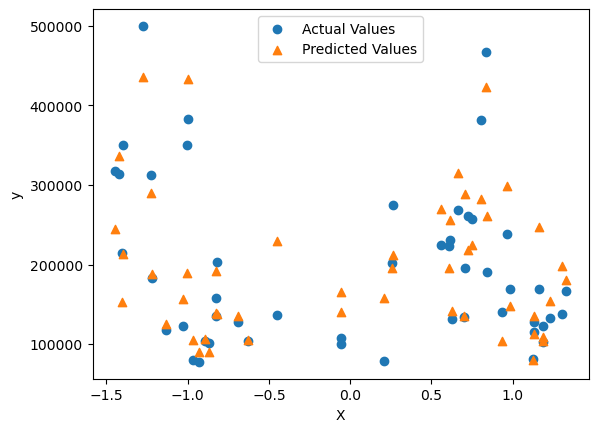

In [10]:
plt.scatter(Xtest_prepared[:50, 0], ytest_prepared[:50], label='Actual Values')
plt.scatter(Xtest_prepared[:50, 0], ypred[:50], label='Predicted Values', marker='^')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()

# little visualization of a small subset of the predicted versus actual values

In [11]:
# Train with RandomForest


RFRegressor = RandomForestRegressor(max_depth = 10, 
                                    min_samples_leaf=10,
                                    random_state=42, max_features = 0.8,
                                    n_estimators = 500, max_samples = 0.5,
                                    n_jobs=-1)

RFRegressor.fit(Xtrain_prepared,np.ravel(ytrain_prepared))



test_predictions = RFRegressor.predict(Xtest_prepared)
train_predictions = RFRegressor.predict(Xtrain_prepared)

test_rmse = mean_squared_error(ytest_prepared, test_predictions, squared=False)
train_rmse = mean_squared_error(ytrain_prepared, train_predictions, squared=False)

print(Xtrain_prepared.shape)
print("RandomForestRegressor: ")
print("train, test RMSEs: ", train_rmse, test_rmse) # prints
print("train, test error rates:", train_rmse / np.mean(ytrain_prepared),#.values,
                                 test_rmse / np.mean(ytest_prepared))#.values)

#here RF gives us better error rate (about 26%), compared with other methods including 
#LR, SGDRegressor, SVR, DecisionTree (about 32-56%)   

(15480, 16)
RandomForestRegressor: 
train, test RMSEs:  48017.802043270574 53426.6889157852
train, test error rates: 0.23258741817613288 0.2567706972575639


In [12]:
# Hypertune RandomForest

param_grid = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [4, 10, 15]
}

# Create a RandomForestRegressor
RFRegressor = RandomForestRegressor(min_samples_leaf=10,
                                    random_state=42, max_features = 0.8,
                                    max_samples = 0.5,
                                    n_jobs=-1)

# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=RFRegressor, param_grid=param_grid, scoring='neg_root_mean_squared_error', cv=5, verbose=3)
grid_search.fit(Xtrain_prepared, ytrain_prepared)

# Retrieve the best hyperparameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Make predictions on the testing data
test_predictions = best_model.predict(Xtest_prepared)
train_predictions = best_model.predict(Xtrain_prepared)

# Evaluate the performance
test_rmse = mean_squared_error(ytest_prepared, test_predictions, squared=False)
train_rmse = mean_squared_error(ytrain_prepared, train_predictions, squared=False)

print(Xtrain_prepared.shape)
print("RandomForestRegressor: ")
print(best_params)
print("train, test RMSEs: ", train_rmse, test_rmse) # prints
print("train, test error rates:", train_rmse / np.mean(ytrain_prepared),#.values,
                                 test_rmse / np.mean(ytest_prepared))#.values)


Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV 1/5] END max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=-61955.187 total time=   0.3s
[CV 2/5] END max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=-61217.121 total time=   0.3s
[CV 3/5] END max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=-61093.975 total time=   0.3s
[CV 4/5] END max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=-63509.916 total time=   0.3s
[CV 5/5] END max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=-65170.667 total time=   0.3s
[CV 1/5] END max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=500;, score=-61696.310 total time=   1.2s
[CV 2/5] END max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=500;, score=-61302.727 total time=   1.2s
[CV 3/5] END max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=500;

In [13]:
best_params

{'max_depth': 20,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 1000}

In [14]:
# Train final with RandomForest


RFRegressor = RandomForestRegressor(max_depth = 20, 
                                    min_samples_leaf=4, min_samples_split=2,
                                    random_state=42, max_features = 0.8,
                                    n_estimators = 1000, max_samples = 0.5,
                                    n_jobs=-1)

RFRegressor.fit(Xtrain_prepared,np.ravel(ytrain_prepared))



test_predictions = RFRegressor.predict(Xtest_prepared)
train_predictions = RFRegressor.predict(Xtrain_prepared)

test_rmse = mean_squared_error(ytest_prepared, test_predictions, squared=False)
train_rmse = mean_squared_error(ytrain_prepared, train_predictions, squared=False)

print(Xtrain_prepared.shape)
print("RandomForestRegressor: ")
print("train, test RMSEs: ", train_rmse, test_rmse) # prints
print("train, test error rates:", train_rmse / np.mean(ytrain_prepared),#.values,
                                 test_rmse / np.mean(ytest_prepared))#.values)


forest_scores = {"RMSE": test_rmse, "Error Rate": test_rmse / np.mean(ytest_prepared)}

#hypertuning improvies error rate by 2%

(15480, 16)
RandomForestRegressor: 
train, test RMSEs:  38524.129043660614 50645.08405471659
train, test error rates: 0.18660220440066816 0.24340219858834186


In [15]:
# Train with AdaBoostRegressor



adaRegressor = AdaBoostRegressor(DecisionTreeRegressor(max_depth = 10, 
                                    min_samples_leaf=10,
                                    random_state=42, max_features = 0.8), 
                                 n_estimators = 500, learning_rate = 0.01)


adaRegressor.fit(Xtrain_prepared,np.ravel(ytrain_prepared))



adatest_predictions = adaRegressor.predict(Xtest_prepared)
adatrain_predictions = adaRegressor.predict(Xtrain_prepared)

adatest_rmse = mean_squared_error(ytest_prepared, adatest_predictions, squared=False)
adatrain_rmse = mean_squared_error(ytrain_prepared, adatrain_predictions, squared=False)

print(Xtrain_prepared.shape)
print("AdaBoostRegressor: ")
print("train, test RMSEs: ", adatrain_rmse, adatest_rmse) # prints
print("train, test error rates:", adatrain_rmse / np.mean(ytrain_prepared),#.values,
                                 adatest_rmse / np.mean(ytest_prepared))#.values)

ada_scores = {"RMSE": adatest_rmse, "Error Rate": adatest_rmse / np.mean(ytest_prepared)}

# Error Rate is 0.24718709, slightly worse than Forest

(15480, 16)
AdaBoostRegressor: 
train, test RMSEs:  40064.947707959436 51432.61306114301
train, test error rates: 0.19406558297605392 0.24718709292101168


In [16]:
# Hypertune AdaBoostRegressor

param_grid = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.1, 1.0],
    'loss': ['linear', 'square', 'exponential']
}

adaRegressor = AdaBoostRegressor(DecisionTreeRegressor(max_depth = 10, 
                                    min_samples_leaf=10,
                                    random_state=42, max_features = 0.8))

# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=adaRegressor, param_grid=param_grid, scoring='neg_root_mean_squared_error', cv=3, verbose=3)
grid_search.fit(Xtrain_prepared, ytrain_prepared)

# Retrieve the best hyperparameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Make predictions on the testing data
test_predictions = best_model.predict(Xtest_prepared)
train_predictions = best_model.predict(Xtrain_prepared)

# Evaluate the performance
test_rmse = mean_squared_error(ytest_prepared, test_predictions, squared=False)
train_rmse = mean_squared_error(ytrain_prepared, train_predictions, squared=False)


adatest_predictions = best_model.predict(Xtest_prepared)
adatrain_predictions = best_model.predict(Xtrain_prepared)

adatest_rmse = mean_squared_error(ytest_prepared, adatest_predictions, squared=False)
adatrain_rmse = mean_squared_error(ytrain_prepared, adatrain_predictions, squared=False)

print(f"best parameters: {best_params}")

print(Xtrain_prepared.shape)
print("AdaBoostRegressor: ")
print("train, test RMSEs: ", adatrain_rmse, adatest_rmse) # prints
print("train, test error rates:", adatrain_rmse / np.mean(ytrain_prepared),#.values,
                                 adatest_rmse / np.mean(ytest_prepared))#.values)

ada_scores = {"RMSE": adatest_rmse, "Error Rate": adatest_rmse / np.mean(ytest_prepared)}

#hypertuning took way to long for barely any improvement, still worse than RandomForest

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV 1/3] END learning_rate=0.01, loss=linear, n_estimators=100;, score=-52895.925 total time=   8.6s
[CV 2/3] END learning_rate=0.01, loss=linear, n_estimators=100;, score=-52439.002 total time=   8.6s
[CV 3/3] END learning_rate=0.01, loss=linear, n_estimators=100;, score=-54330.795 total time=   8.6s
[CV 1/3] END learning_rate=0.01, loss=linear, n_estimators=200;, score=-52172.004 total time=  17.1s
[CV 2/3] END learning_rate=0.01, loss=linear, n_estimators=200;, score=-52478.985 total time=  17.1s
[CV 3/3] END learning_rate=0.01, loss=linear, n_estimators=200;, score=-54533.752 total time=  17.1s
[CV 1/3] END learning_rate=0.01, loss=linear, n_estimators=500;, score=-51588.915 total time=  41.9s
[CV 2/3] END learning_rate=0.01, loss=linear, n_estimators=500;, score=-51872.396 total time=  42.0s
[CV 3/3] END learning_rate=0.01, loss=linear, n_estimators=500;, score=-53799.196 total time=  41.8s
[CV 1/3] END learning_rate=0.0

In [17]:
# Train with GradientBoostingRegressor

gradientRegressor = GradientBoostingRegressor(max_depth = 10, 
                                    min_samples_leaf=10,
                                    random_state=42, max_features = 0.8, 
                                    n_estimators = 500, learning_rate = 0.01,
                                    subsample = 0.9)

gradientRegressor.fit(Xtrain_prepared,np.ravel(ytrain_prepared))



gradienttest_predictions = gradientRegressor.predict(Xtest_prepared)
gradienttrain_predictions = gradientRegressor.predict(Xtrain_prepared)

gradienttest_rmse = mean_squared_error(ytest_prepared, gradienttest_predictions, squared=False)
gradienttrain_rmse = mean_squared_error(ytrain_prepared, gradienttrain_predictions, squared=False)

print(Xtrain_prepared.shape)
print("GradientBoostingRegressor: ")
print("train, test RMSEs: ", gradienttrain_rmse, gradienttest_rmse) # prints
print("train, test error rates:", gradienttrain_rmse / np.mean(ytrain_prepared),#.values,
                                 gradienttest_rmse / np.mean(ytest_prepared))#.values)

gradient_scores = {"RMSE": gradienttest_rmse, "Error Rate": gradienttest_rmse / np.mean(ytest_prepared)}

#train, test error rates: [0.13957056] [0.224388] with subsample = 0.9 => error rate reduces 2%, 
#compared to AdaBoostRegressor

(15480, 16)
GradientBoostingRegressor: 
train, test RMSEs:  28814.42073690006 46688.78977041334
train, test error rates: 0.13957056425442194 0.22438809791034683


In [18]:
# Hypertune Gradient

param_grid = {
    'learning_rate': [0.01, 0.1, 1.0],
    'loss': ['squared_error', 'absolute_error', 'huber', 'quantile'],
    'subsample': [0.8, 0.9, 1.0],
     'n_iter_no_change': [5, 10, 50, None]
}

gradientRegressor = GradientBoostingRegressor(max_depth = 10, 
                                    min_samples_leaf=10,
                                    random_state=42, max_features = 0.8, 
                                    n_estimators = 50) #set it to 50 because 500 would take too long
# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=gradientRegressor, param_grid=param_grid, scoring='neg_root_mean_squared_error', cv=3, verbose=3)
grid_search.fit(Xtrain_prepared, ytrain_prepared)

# Retrieve the best hyperparameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

gradienttest_predictions = best_model.predict(Xtest_prepared)
gradienttrain_predictions = best_model.predict(Xtrain_prepared)

gradienttest_rmse = mean_squared_error(ytest_prepared, gradienttest_predictions, squared=False)
gradienttrain_rmse = mean_squared_error(ytrain_prepared, gradienttrain_predictions, squared=False)

print(f"best parameters: {best_params}")

print(Xtrain_prepared.shape)
print("GradientBoostingRegressor: ")
print("train, test RMSEs: ", gradienttrain_rmse, gradienttest_rmse) # prints
print("train, test error rates:", gradienttrain_rmse / np.mean(ytrain_prepared),#.values,
                                 gradienttest_rmse / np.mean(ytest_prepared))#.values)

gradient_scores = {"RMSE": gradienttest_rmse, "Error Rate": gradienttest_rmse / np.mean(ytest_prepared)}

Fitting 3 folds for each of 144 candidates, totalling 432 fits
[CV 1/3] END learning_rate=0.01, loss=squared_error, n_iter_no_change=5, subsample=0.8;, score=-81949.120 total time=   3.8s
[CV 2/3] END learning_rate=0.01, loss=squared_error, n_iter_no_change=5, subsample=0.8;, score=-82303.796 total time=   3.8s
[CV 3/3] END learning_rate=0.01, loss=squared_error, n_iter_no_change=5, subsample=0.8;, score=-82593.556 total time=  47.8s
[CV 1/3] END learning_rate=0.01, loss=squared_error, n_iter_no_change=5, subsample=0.9;, score=-82015.059 total time= 1.4min
[CV 2/3] END learning_rate=0.01, loss=squared_error, n_iter_no_change=5, subsample=0.9;, score=-82121.937 total time= 1.7min
[CV 3/3] END learning_rate=0.01, loss=squared_error, n_iter_no_change=5, subsample=0.9;, score=-82546.803 total time= 1.1min
[CV 1/3] END learning_rate=0.01, loss=squared_error, n_iter_no_change=5, subsample=1.0;, score=-81935.201 total time= 1.9min
[CV 2/3] END learning_rate=0.01, loss=squared_error, n_iter_no

In [19]:
# Train with GradientBoostingRegressor now with 500 estimators using hypertuned parameters

gradientRegressor = GradientBoostingRegressor(loss='huber', max_depth = 10, 
                                    min_samples_leaf=10,
                                    random_state=42, max_features = 0.8, 
                                    n_estimators = 500, learning_rate = 0.1,
                                    subsample = 0.8) 

gradientRegressor.fit(Xtrain_prepared,np.ravel(ytrain_prepared))



gradienttest_predictions = gradientRegressor.predict(Xtest_prepared)
gradienttrain_predictions = gradientRegressor.predict(Xtrain_prepared)

gradienttest_rmse = mean_squared_error(ytest_prepared, gradienttest_predictions, squared=False)
gradienttrain_rmse = mean_squared_error(ytrain_prepared, gradienttrain_predictions, squared=False)

print(Xtrain_prepared.shape)
print("GradientBoostingRegressor: ")
print("train, test RMSEs: ", gradienttrain_rmse, gradienttest_rmse) # prints
print("train, test error rates:", gradienttrain_rmse / np.mean(ytrain_prepared),#.values,
                                 gradienttest_rmse / np.mean(ytest_prepared))#.values)

gradient_scores = {"RMSE": gradienttest_rmse, "Error Rate": gradienttest_rmse / np.mean(ytest_prepared)}

#train, test error rates: [0.0832701] [0.2211998] => error rate reduces 0.3%, 

(15480, 16)
GradientBoostingRegressor: 
train, test RMSEs:  17191.17060458117 46025.40763056079
train, test error rates: 0.08327015848709227 0.22119985813627716


In [20]:
# Histogram Gradient Boosting

HGBRegressor = HistGradientBoostingRegressor(
         max_depth=10, min_samples_leaf=10,
         max_iter=500,
         learning_rate=0.01, random_state=42)



HGBRegressor.fit(Xtrain_prepared,np.ravel(ytrain_prepared))


HGBtest_predictions = HGBRegressor.predict(Xtest_prepared)
HGBtrain_predictions = HGBRegressor.predict(Xtrain_prepared)

HGBtest_rmse = mean_squared_error(ytest_prepared, HGBtest_predictions, squared=False)
HGBtrain_rmse = mean_squared_error(ytrain_prepared, HGBtrain_predictions, squared=False)

print(Xtrain_prepared.shape)
print("HistogramGradienttBoostingRegressor: ")
print("train, test RMSEs: ", HGBtrain_rmse, gradienttest_rmse) # prints
print("train, test error rates:", HGBtrain_rmse / np.mean(ytrain_prepared),#.values,
                                 HGBtest_rmse / np.mean(ytest_prepared))#.values)

hist_scores = {"RMSE": HGBtest_rmse, "Error Rate": HGBtest_rmse / np.mean(ytest_prepared)}

#train, test error rates: [0.2128782] [0.2364132], about 1.5% worse than GradientBoosting
# but HGB works much faster

(15480, 16)
HistogramGradienttBoostingRegressor: 
train, test RMSEs:  43948.83862661103 46025.40763056079
train, test error rates: 0.21287827582761068 0.23641328883313348


In [21]:
# hypertune Histogram Gradient Boosting

param_grid = {
    'learning_rate': [0.01, 0.1, 1.0],
    'l2_regularization': [0.0, 0.1, 0.2],
    'loss': ['squared_error', 'absolute_error', 'gamma', 'poisson', 'quantile'],
}

HGBRegressor = HistGradientBoostingRegressor(
         max_depth=10, min_samples_leaf=10,
         max_iter=500, quantile=0.5,
         random_state=42)

# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=HGBRegressor, param_grid=param_grid, scoring='neg_root_mean_squared_error', cv=3, verbose=3)
grid_search.fit(Xtrain_prepared, ytrain_prepared)

# Retrieve the best hyperparameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_


HGBtest_predictions = best_model.predict(Xtest_prepared)
HGBtrain_predictions = best_model.predict(Xtrain_prepared)

HGBtest_rmse = mean_squared_error(ytest_prepared, HGBtest_predictions, squared=False)
HGBtrain_rmse = mean_squared_error(ytrain_prepared, HGBtrain_predictions, squared=False)

print(f"best parameters: {best_params}")

print(Xtrain_prepared.shape)
print("HistogramGradienttBoostingRegressor: ")
print("train, test RMSEs: ", HGBtrain_rmse, gradienttest_rmse) # prints
print("train, test error rates:", HGBtrain_rmse / np.mean(ytrain_prepared),#.values,
                                 HGBtest_rmse / np.mean(ytest_prepared))#.values)

hist_scores = {"RMSE": HGBtest_rmse, "Error Rate": HGBtest_rmse / np.mean(ytest_prepared)}


Fitting 3 folds for each of 45 candidates, totalling 135 fits
[CV 1/3] END l2_regularization=0.0, learning_rate=0.01, loss=squared_error;, score=-48839.854 total time=   2.7s
[CV 2/3] END l2_regularization=0.0, learning_rate=0.01, loss=squared_error;, score=-48708.967 total time=   2.6s
[CV 3/3] END l2_regularization=0.0, learning_rate=0.01, loss=squared_error;, score=-50468.333 total time=   2.6s
[CV 1/3] END l2_regularization=0.0, learning_rate=0.01, loss=absolute_error;, score=-51107.714 total time=   3.6s
[CV 2/3] END l2_regularization=0.0, learning_rate=0.01, loss=absolute_error;, score=-50796.706 total time=   3.6s
[CV 3/3] END l2_regularization=0.0, learning_rate=0.01, loss=absolute_error;, score=-52877.454 total time=   3.6s
[CV 1/3] END l2_regularization=0.0, learning_rate=0.01, loss=gamma;, score=-48752.312 total time=   2.7s
[CV 2/3] END l2_regularization=0.0, learning_rate=0.01, loss=gamma;, score=-49239.666 total time=   2.7s
[CV 3/3] END l2_regularization=0.0, learning_ra

In [22]:
# Histogram Gradient Boosting with tuned params

HGBRegressor = HistGradientBoostingRegressor(
         max_depth=10, min_samples_leaf=10,
         max_iter=500, l2_regularization=0.2,
         learning_rate=0.1, random_state=42)



HGBRegressor.fit(Xtrain_prepared,np.ravel(ytrain_prepared))


HGBtest_predictions = HGBRegressor.predict(Xtest_prepared)
HGBtrain_predictions = HGBRegressor.predict(Xtrain_prepared)

HGBtest_rmse = mean_squared_error(ytest_prepared, HGBtest_predictions, squared=False)
HGBtrain_rmse = mean_squared_error(ytrain_prepared, HGBtrain_predictions, squared=False)

print(Xtrain_prepared.shape)
print("HistogramGradienttBoostingRegressor: ")
print("train, test RMSEs: ", HGBtrain_rmse, gradienttest_rmse) # prints
print("train, test error rates:", HGBtrain_rmse / np.mean(ytrain_prepared),#.values,
                                 HGBtest_rmse / np.mean(ytest_prepared))#.values)

hist_scores = {"RMSE": HGBtest_rmse, "Error Rate": HGBtest_rmse / np.mean(ytest_prepared)}

# only .3% worse than gradient and a whole lot faster

(15480, 16)
HistogramGradienttBoostingRegressor: 
train, test RMSEs:  33067.543332825226 46025.40763056079
train, test error rates: 0.1601717321896261 0.2242036883210345


In [23]:
# stacking

stackRegressor = StackingRegressor(estimators = [
    ('GradientBoostingRegressor', GradientBoostingRegressor(loss='huber', max_depth = 10, 
                                    min_samples_leaf=10,
                                    random_state=42, max_features = 0.8, 
                                    n_estimators = 500, learning_rate = 0.1,
                                    subsample = 0.8)),
        
    ('RF', RandomForestRegressor(max_depth = 20, 
                                    min_samples_leaf=4, min_samples_split=2,
                                    random_state=42, max_features = 0.8,
                                    n_estimators = 1000, max_samples = 0.5,
                                    n_jobs=-1))
    ],
                                   
    final_estimator = LinearRegression(),
    cv = 5, n_jobs = -1
)

stackRegressor.fit(Xtrain_prepared,np.ravel(ytrain_prepared))


stacktest_predictions = stackRegressor.predict(Xtest_prepared)
stacktrain_predictions = stackRegressor.predict(Xtrain_prepared)

stacktest_rmse = mean_squared_error(ytest_prepared, stacktest_predictions, squared=False)
stacktrain_rmse = mean_squared_error(ytrain_prepared, stacktrain_predictions, squared=False)

print(Xtrain_prepared.shape)
print("stackingRegressor: ")
print("train, test RMSEs: ", stacktrain_rmse, stacktest_rmse) # prints
print("train, test error rates:", stacktrain_rmse / np.mean(ytrain_prepared),#.values,
                                 stacktest_rmse / np.mean(ytest_prepared))#.values)

stack_scores = {"RMSE": stacktest_rmse, "Error Rate": stacktest_rmse / np.mean(ytest_prepared)}

#train, test error rates: [0.08219538] [0.22107629] 
#the ensemble's performance is ever so slightly better than the GradientBoostingRegressor is on the test
#but the train error rate goes down (by 2%). That is good as it makes zoom for regularization to
#reducing the error rate on test

#your turn:
#1 try to include the best versions of ensembles you have got in the stacking ensemble to 
#get better final model.


(15480, 16)
stackingRegressor: 
train, test RMSEs:  16969.283497424538 45999.69722882884
train, test error rates: 0.08219538731506681 0.2210762929685032


In [24]:
scores = pd.DataFrame(data=(voting_scores, bagging_scores, forest_scores, ada_scores, gradient_scores, hist_scores, stack_scores),
                     index=["VotingRegressor", "BaggingRegressor", "RandomForest", "AdaBoostRegressor", 
                            "GradientBoostingRegressor", "HistGradientBoostingRegressor", "StackingRegressor"]
                     ).sort_values("Error Rate", ascending=False)
scores

,RMSE,Error Rate
VotingRegressor,73709.641585,0.354251
BaggingRegressor,65270.918856,0.313695
AdaBoostRegressor,51582.916429,0.247909
RandomForest,50645.084055,0.243402
HistGradientBoostingRegressor,46650.419373,0.224204
GradientBoostingRegressor,46025.407631,0.221200
StackingRegressor,45999.697229,0.221076


## Conclusions

The best overall algorithm ended up being Stacking Regressor with and error rate of 22.1076%, which is pretty solid. It was only a little bit better than Gradient and histogram boosting, but this makes sense as the stacking regressor combines the strong algorithms to make a slight stronger algorithm. For my stacking Regressor I used Random forest and GradientBoostin to get the final model. I choose not to use hist because it is nearly the same as Gradient, only slightly worse, so it would feel redundant. It is not surprising that Voting performed the worst, because it uses a lot of weak algorithms, includong ones that had high error rates, like SVR and SGDRegressor. I ended up using DecisionTree for most bass algorithms because it performed the best out of the regressors in the Voting, so it makes sense why Gradient did so well, as it optimizes for DecisionTree. Overall this leads to aStacking being the best, because it uses the strong algorithms in GradientBoosting and RandomForest, and combines them into a slightly better model.